In [1]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device ,torch.cuda.is_available())

cuda True


In [2]:
torch.cuda.is_available()

True

In [21]:
import sys,os, pickle

import torch.nn as nn
from transformers import BertModel, BertTokenizer
from transformers import BertForMaskedLM
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, random_split
from transformers import AdamW
from tqdm import tqdm  # for our progress bar

from sklearn.metrics import precision_recall_fscore_support , accuracy_score, f1_score
import numpy as np
from transformers import AutoModelForSequenceClassification

import random


EXPERIMENT_NAME="TYPE_WRITER_BERT_SLIDING_WINDOW"

BATCH_SIZE = 30
MAX_TOKEN_SIZE = 512


In [4]:
def fix_types(type_name):
    global TYPE_FIX_MAP
    
    prev_type_name= type_name
    
    if '*' in type_name:
        if type_name.rindex('*')>0:#reduce to single * (rightmost, ignore array before that)
            type_name = type_name[ type_name.rindex('*'): ]
    if 'array_' in type_name:
        if type_name.rindex('array_')>0:
            type_name = type_name[ type_name.rindex('array_'): ]
    if 'unsigned char' in type_name:
        type_name = type_name.replace('unsigned char' , 'char')
        
        
    if type_name not in TYPE_FIX_MAP:
        TYPE_FIX_MAP[prev_type_name] = type_name
    return type_name



In [5]:
DATA_PATH = '/media/raisul/nahid_personal/no_address/instructions_and_type_data_100k/'
MODEL_SAVE_PATH =  '/home/raisul/models/'
TYPE_COUNT ={}
FINAL_TYPE_COUNT = {}
TYPE_PROBABILITY = {}


REJECT = ['union' , 'enumeration' , 'int128' , '_Bool' , 'complex' ,'bool']
TYPE_FIX_MAP = {}
MAX_TYPE_SAMPLE  =20*1000
ALL_INPUT_LIST = []
ALL_INPUT_SLICE_INFO  = []
ALL_LABEL_LIST = []
TYPE_MAPPING = {}

In [6]:

# #TODO dont load all at a time in memry
# def make_dataset():
#     global TYPE_FIX_MAP, REJECT ,TYPE_COUNT,TYPE_MAPPING
#     #count how many real samples
#     for fi,pkl_file_name in enumerate(os.listdir(DATA_PATH)):
#         pkl_path = os.path.join(DATA_PATH,pkl_file_name)
#         with open(pkl_path, 'rb') as file:
#             try:
#                 model_input_list, model_type_list = pickle.load(file)

#             except Exception as e:
#                 pass
#             for i in range(len(model_input_list)):

#                 type_str = fix_types(model_type_list[i])
                
#                 if type_str not in TYPE_COUNT:
#                     TYPE_COUNT[type_str] = 0
#                     FINAL_TYPE_COUNT[type_str] = 0
                
#                 TYPE_COUNT[type_str] +=1
# #         if fi>100:
# #             break
#     print(TYPE_COUNT)
    
#     #remove the unwanted types
#     temp_removed_keys = []
#     for rk in REJECT:
#         for tk in TYPE_COUNT:
#             if rk in tk:
#                 temp_removed_keys.append(tk)
#         for tfm in TYPE_FIX_MAP:
#             if tfm in tk:
#                 temp_removed_keys.append(tk)
#     print('temp_removed_keys',temp_removed_keys)
#     for trk in temp_removed_keys:
#         if trk in TYPE_COUNT:
#             TYPE_COUNT.pop(trk)
#         if trk in FINAL_TYPE_COUNT:
#             FINAL_TYPE_COUNT.pop(trk)
#         if trk in TYPE_FIX_MAP:
#             TYPE_FIX_MAP.pop(trk)
    
#     TYPE_COUNT = {k: v for k, v in sorted(TYPE_COUNT.items(), key=lambda item: item[1] , reverse=True)}


#     ti = 0
#     for key,val in TYPE_COUNT.items():
#         TYPE_MAPPING[key]  = ti
#         ti+=1

#     #make the probability
#     for key in TYPE_COUNT.keys():
#         print(MAX_TYPE_SAMPLE , TYPE_COUNT[key] ,key)
#         TYPE_PROBABILITY[key] = MAX_TYPE_SAMPLE/TYPE_COUNT[key]
    

#     print(TYPE_PROBABILITY)
    
#     #fill dataset with that probability
#     for fi,pkl_file_name in enumerate(os.listdir(DATA_PATH)):
#         pkl_path = os.path.join(DATA_PATH,pkl_file_name)

#         with open(pkl_path, 'rb') as file:
#             try:
#                 model_input_list, model_type_list = pickle.load(file)
#             except Exception as e:
#                 pass
#             for i in range(len(model_input_list)):
                
#                 try:
#                     type_str = TYPE_FIX_MAP[model_type_list[i]]
#                     type_label = TYPE_MAPPING[type_str]

#                     backward_slice , target_slice, forward_slice = model_input_list[i]

#                     if random.random()<=TYPE_PROBABILITY[type_str]:

#                         ALL_INPUT_LIST.append(backward_slice + target_slice + forward_slice)
#                         ALL_INPUT_SLICE_INFO.append([len(backward_slice) , len(target_slice) , len(forward_slice)])
#                         ALL_LABEL_LIST.append(type_label)

#                         FINAL_TYPE_COUNT[type_str]+=1
#                 except:
#                       pass
# #         if fi>100:
# #             break
# make_dataset()

{'int': 11142119, 'char': 435996, 'array_char': 610823, '*char': 1260381, 'array_int': 467527, '*structure': 2129367, 'float': 284881, '*int': 1525841, 'array_float': 17179, 'structure': 190457, 'double': 207751, 'long int': 146642, 'long unsigned int': 57611, '*double': 37006, 'array_double': 12253, 'array_structure': 24893, 'unsigned int': 217346, '*long unsigned int': 7408, 'short unsigned int': 29723, 'long long int': 87504, '*float': 24105, 'enumeration': 22623, '*long int': 23276, 'short int': 37200, '_Bool': 1984, 'long long unsigned int': 66177, 'array_unsigned int': 5133, 'array_long long int': 4344, '*long long int': 6669, 'union': 6065, '*short unsigned int': 4840, 'array_long int': 5138, '*signed char': 4414, 'signed char': 10188, '*unsigned int': 15627, 'array_short int': 1184, '*short int': 7230, '*long long unsigned int': 2061, 'array_long long unsigned int': 2450, 'array_long unsigned int': 1905, '*_Bool': 370, 'array__Bool': 23, '*union': 19396, 'array_union': 129, '*e

In [6]:
data_temp_path = 'data/typedata.ignore.pkl'
# with open(data_temp_path, 'wb') as f:
#     pickle.dump([TYPE_COUNT , TYPE_MAPPING ,ALL_INPUT_LIST, ALL_INPUT_SLICE_INFO ,ALL_LABEL_LIST,FINAL_TYPE_COUNT ], f)
    
    
with open(data_temp_path, 'rb') as file:
    TYPE_COUNT , TYPE_MAPPING ,ALL_INPUT_LIST, ALL_INPUT_SLICE_INFO ,ALL_LABEL_LIST,FINAL_TYPE_COUNT  = pickle.load(file)    

In [7]:
len(ALL_INPUT_LIST)

494530

In [8]:
tokenizer  = BertTokenizer.from_pretrained("./multytask-tokenizer")

#https://github.com/huggingface/tokenizers/issues/247

mask_token_id, look_token_id, eoi_token_id = tokenizer.encode('[MASK] [LOOK] [EOI]')[1:-1]

print(mask_token_id, look_token_id, eoi_token_id)

4 6 5


In [9]:
# Create model instance
#TODO*** USE PRETRAINED
# PATH, local_files_only=True
model = AutoModelForSequenceClassification.from_pretrained( (MODEL_SAVE_PATH +EXPERIMENT_NAME), num_labels=len(TYPE_MAPPING.items()))
model.to(device)




BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:

# Tokenize input text
# inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
# inputs = tokenizer(ALL_INPUT_LIST, max_length= MAX_TOKEN_SIZE,padding='max_length', truncation=True , return_tensors='pt')
# print(inputs.keys())

# labels = ALL_LABEL_LIST.to(device)

In [13]:
# print(inputs.keys())
# print(inputs.token_type_ids)
# inputs.token_type_ids[0][0] =1
# print(inputs.token_type_ids)
# #TODO set token type ids

In [14]:
# class BinaryDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings):
#         self.encodings = encodings
#     def __getitem__(self, idx):
#         return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#     def __len__(self):
#         return len(self.encodings.input_ids)

In [10]:
class BinaryDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        # Tokenize the text
        tokenized_text = (self.tokenizer(text , max_length= MAX_TOKEN_SIZE,padding='max_length', truncation=True , return_tensors='pt')).to(device)
        
        # Convert tokens to input IDs
#         input_ids = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        
        # Create input tensors
#         input_ids = tokenized_text['input_ids']  #torch.tensor(input_ids)
        label = torch.tensor([label]).to(device)
        
        return tokenized_text, label
        
#         return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.texts)

In [11]:
print(len(ALL_INPUT_LIST ), len(ALL_LABEL_LIST))

494530 494530


In [13]:
dataset = BinaryDataset(ALL_INPUT_LIST, ALL_LABEL_LIST,tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

TRAIN_LABELS = ALL_LABEL_LIST[:train_size]



In [14]:
# TYPE_PROBABILITY
total_samples = sum(list(TYPE_COUNT.values()))
TYPE_WEIGHTS = [ (total_samples/i) for i in list(TYPE_COUNT.values()) ]
weights = [0] * len(train_dataset)
for indx, tlabel in enumerate(TRAIN_LABELS):
    type_index =  tlabel
    weights [indx]= TYPE_WEIGHTS[type_index]
    

In [15]:

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(train_dataset), replacement=True)
train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE ,shuffle=True) #sampler = sampler)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
# global_task2_metrices, global_task1_metrices ,v_global_task1_metrices, v_global_task2_metrices

from numpy import *
import math
import matplotlib.pyplot as plt


def plot_graph(task1_metrices,   v_task1_metrices, label = "TypeGraph" ):
    
    plt.ioff()

    font_size = 10
    x_labels = [ i for i in range(len(task1_metrices)) ]
    
    task1_f1 = [ i['f1'] for i in task1_metrices ]

    
    v_task1_f1 = [ i['f1'] for i in v_task1_metrices ]

    

    plt.ylabel(' F1 ',fontsize=font_size)
    plt.plot(x_labels, task1_f1 , 'r') 

    
    plt.plot(x_labels, v_task1_f1 , 'r' , linestyle = '--') 

    
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend([' Type Train',  'Type Val' ], loc='upper left')
    
#     plt.savefig('./output/'+label+'_f1.pdf')
    plt.close()
    plt.show()
    
    ################################
    ################# LOSS #########
    ################################
    
    task1_loss = [ i['loss'] for i in task1_metrices ]

    
    v_task1_loss = [ i['loss'] for i in v_task1_metrices ]
    

    plt.ylabel(' LOSS ',fontsize=font_size)
    plt.plot(x_labels, task1_loss , 'r') 
    
    plt.plot(x_labels, v_task1_loss , 'r' , linestyle = '--') 

    
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend([' Type Train',  'Type Val'], loc='upper left')
    
#     plt.savefig('./output/'+label+'_loss.pdf')
    plt.close()
    plt.show()
    
    

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(true_labels, predicted_labels, label='confusion_matrix'):

    class_labels = list(TYPE_MAPPING.keys())  
    class_labels = [c for c in class_labels]

    cm = confusion_matrix(true_labels, predicted_labels ) 
    
    conf_per_class = cm.diagonal()/cm.sum(axis=1)
    average_acc = sum([i for i in conf_per_class  if not math.isnan(i)] )/len(conf_per_class)
    
    print('CONFUSION PER CLASS',conf_per_class,average_acc)
    
    fig, ax = plt.subplots(figsize=(20, 20))
    
    res = sns.heatmap(cm,
            annot=True , cmap="Blues" , fmt='g' , xticklabels=class_labels,linewidths = .01,
                      yticklabels=class_labels,linecolor="Gray")
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    
    plt.ylabel('Actual',fontsize=13)
    plt.xlabel('Prediction',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
#     plt.savefig('./output/'+label+'_conf.pdf',dpi=200)
    plt.show()
    plt.close()
    
    f1_score_per_class = f1_score(true_labels, predicted_labels, average=None)
    f1_scores_with_labels = {label:score for label,score in zip(class_labels, f1_score_per_class)}
# plot_confusion_matrix(v_ground_truth_s , v_prediction_s ,label=EXPERIMENT_NAME)

In [23]:


# initialize optimizer
optim = AdamW( model.parameters() , lr=5e-6)
criterion = nn.CrossEntropyLoss()

In [24]:
def training_loop(model ,data_loop, is_training = False):
    
    prediction_s, ground_truth_s = [], []
    losses = []

    for N,batch in enumerate(data_loop):
        
        
        # Forward pass
        if is_training == True:
            optim.zero_grad()
        
        batch_input, batch_labels = batch
        if len(batch_labels)<BATCH_SIZE:
            continue
        batch_input_ids= batch_input['input_ids']
        batch_attention_mask=batch_input['attention_mask']
        batch_token_type_ids =batch_input['token_type_ids']

        outputs = model(input_ids=batch_input_ids.squeeze(),
                        attention_mask=batch_attention_mask.squeeze(),
                        token_type_ids=batch_token_type_ids.squeeze(),
                        labels=batch_labels )
        
#

        loss = outputs.loss
        losses.append(loss.item())
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        


        prediction_s.extend(predictions.detach().cpu().numpy().flatten())
        ground_truth_s.extend(batch_labels.detach().cpu().numpy().flatten())


        if is_training == True:
            loss.backward()
            optim.step()


        # print relevant info to progress bar
        data_loop.set_description(f'Epoch {ecpoch}')
        data_loop.set_postfix(loss=loss.item())

    ###### Training Scores
    accuracy = accuracy_score(ground_truth_s, prediction_s)    
    precision, recall, f1, _ = precision_recall_fscore_support(ground_truth_s,prediction_s,average='weighted')
    metrices = {'accuracy':accuracy ,
                      'precision':precision, 
                      'recall':recall, 
                      'f1':f1,
                      'loss': (sum(losses) / len(losses))}
    


    return metrices , prediction_s, ground_truth_s
    

Epoch 0: 100%|█| 3297/3297 [11:16<00:00,  4.8


CONFUSION PER CLASS [0.97937107 0.97308432 0.98042287 0.96866359 0.97440837 0.97841105
 0.99722454 0.99624531 0.98851722 0.99110452 0.95444361 0.97068655
 0.94371436 0.99250562 0.97411082 0.99845201 0.99506741 0.99801193
 0.98651134 0.99522472 0.99630314 0.99436024 0.99186165 0.99809796
 0.99699549 0.99093445 0.99772899 0.9844841  0.98834746 0.98559671
 0.99481865 1.         0.96642336 0.9976247  0.98408488 0.99749373
 0.99468085 0.97311828 0.97435897 1.        ] 0.9860873710982025


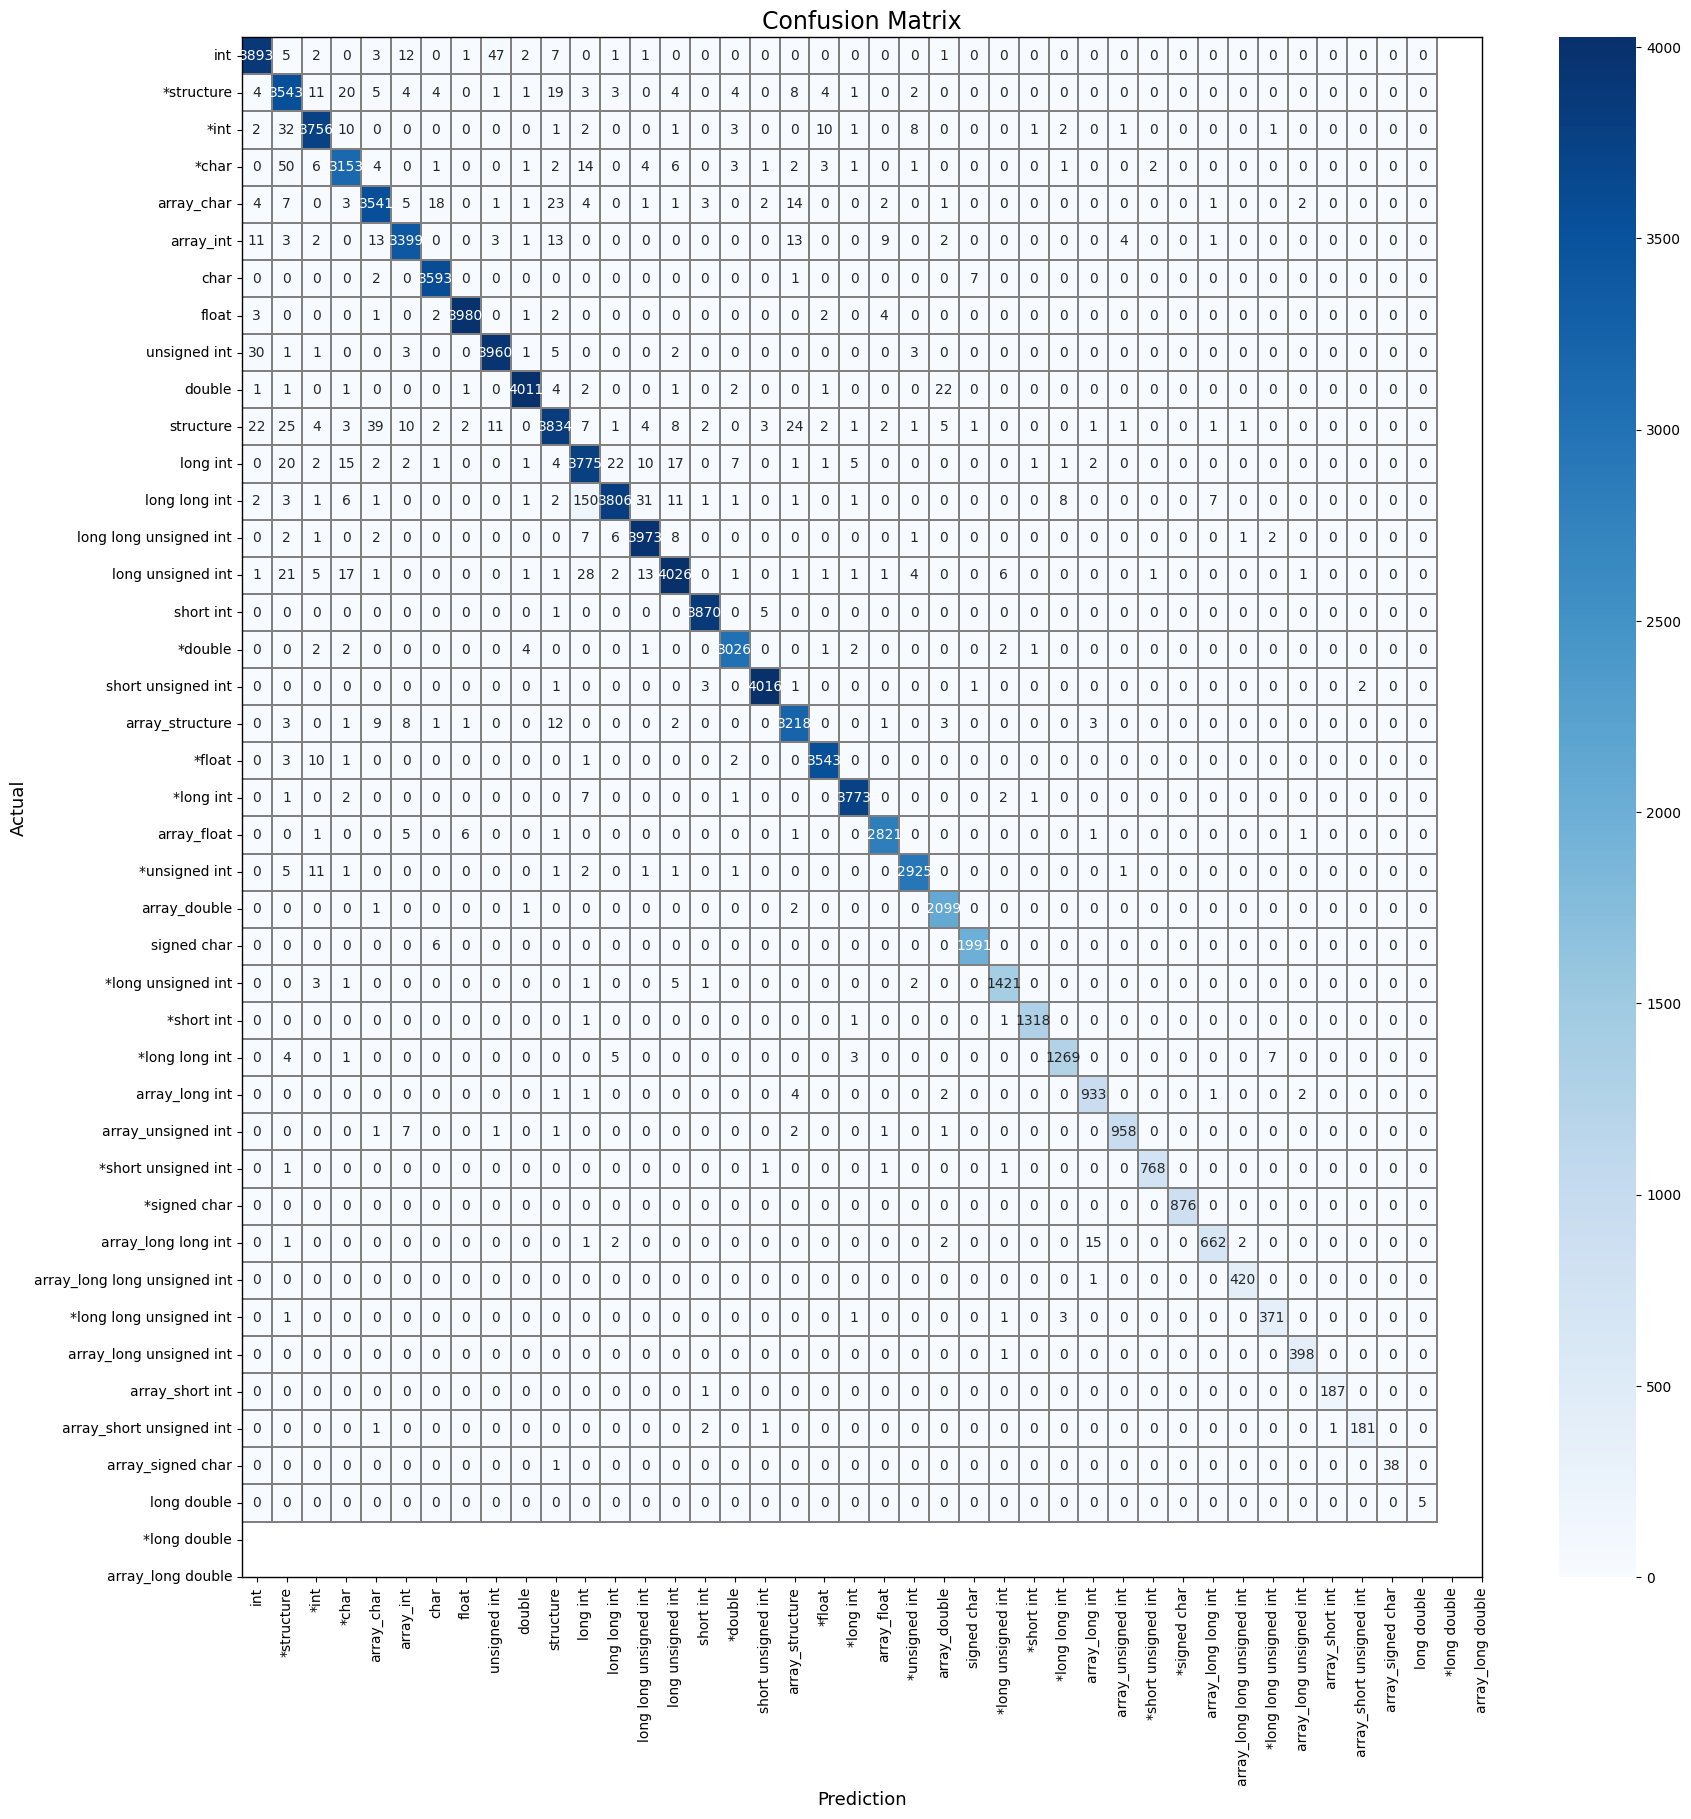

v_metrices:  {'accuracy': 0.9843244336569579, 'precision': 0.9844067244609673, 'recall': 0.9843244336569579, 'f1': 0.9843188540279356, 'loss': 0.07957929127577659}


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

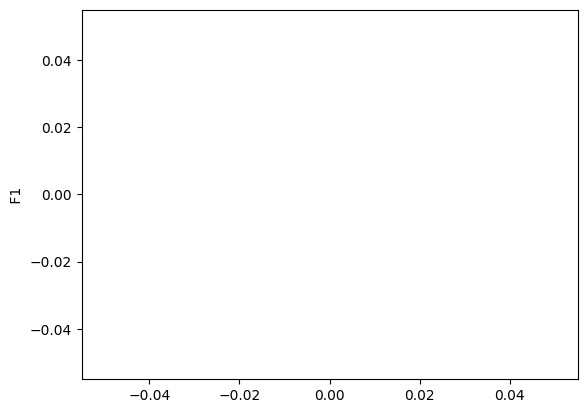

In [26]:
EPOCHS = 1


global_metrices = []
v_global_metrices = []


for ecpoch in range(EPOCHS):
    
    
    with torch.no_grad():
        model.eval()
        validation_loop = tqdm(validation_loader, leave=True)
        v_metrices, v_prediction_s, v_ground_truth_s  = training_loop(model ,validation_loop, is_training = False)
        plot_confusion_matrix(v_ground_truth_s , v_prediction_s ,label=EXPERIMENT_NAME)
        print('v_metrices: ',v_metrices)
        v_global_metrices.append(v_metrices)
    plot_graph(global_metrices,v_global_metrices , label = EXPERIMENT_NAME)
#     break



In [ ]:
print('Alhamdulillah')